In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import random
import scipy

In this challenge you will implement stochastic simulations of two synthetic biological circuits. The synthetic genetic switch, and the repressilator were described in two back–to–back papers in Nature in 2000. Please follow the link on the website to the two papers.

In this challenge two groups will report on the deterministic version of models of these circuits, while the other two will report on the stochastic versions. The last part of each question asks that you compare the results of the simulations. Therefore groups 1 and 2, and groups 3 and 4 will need to work together on each project.

Group #4

Consider the stochastic repressilator described in Loinger, et al (the one discussing the repressilator) and in Elowitz and Leibler.

- Using both repressilator papers as a guide, write down a Master equation describing the stochastic version of Eq. 1 of Loinger (i.e., a simple repressilator with reactions as described in the Michaelis-Menten kinetics section of that paper).

- Suggest a method for detecting oscillation-like behavior in a stochastic process. Apply your method to stochastic simulations of the simple repressilator for some of the same cases considered by Group 3 above (i.e., you do not need attempt a full phase portrait, but choose a few parameter sets that correspond to those explored by group 3, and try to find at least one case where oscillations appear to be happening).


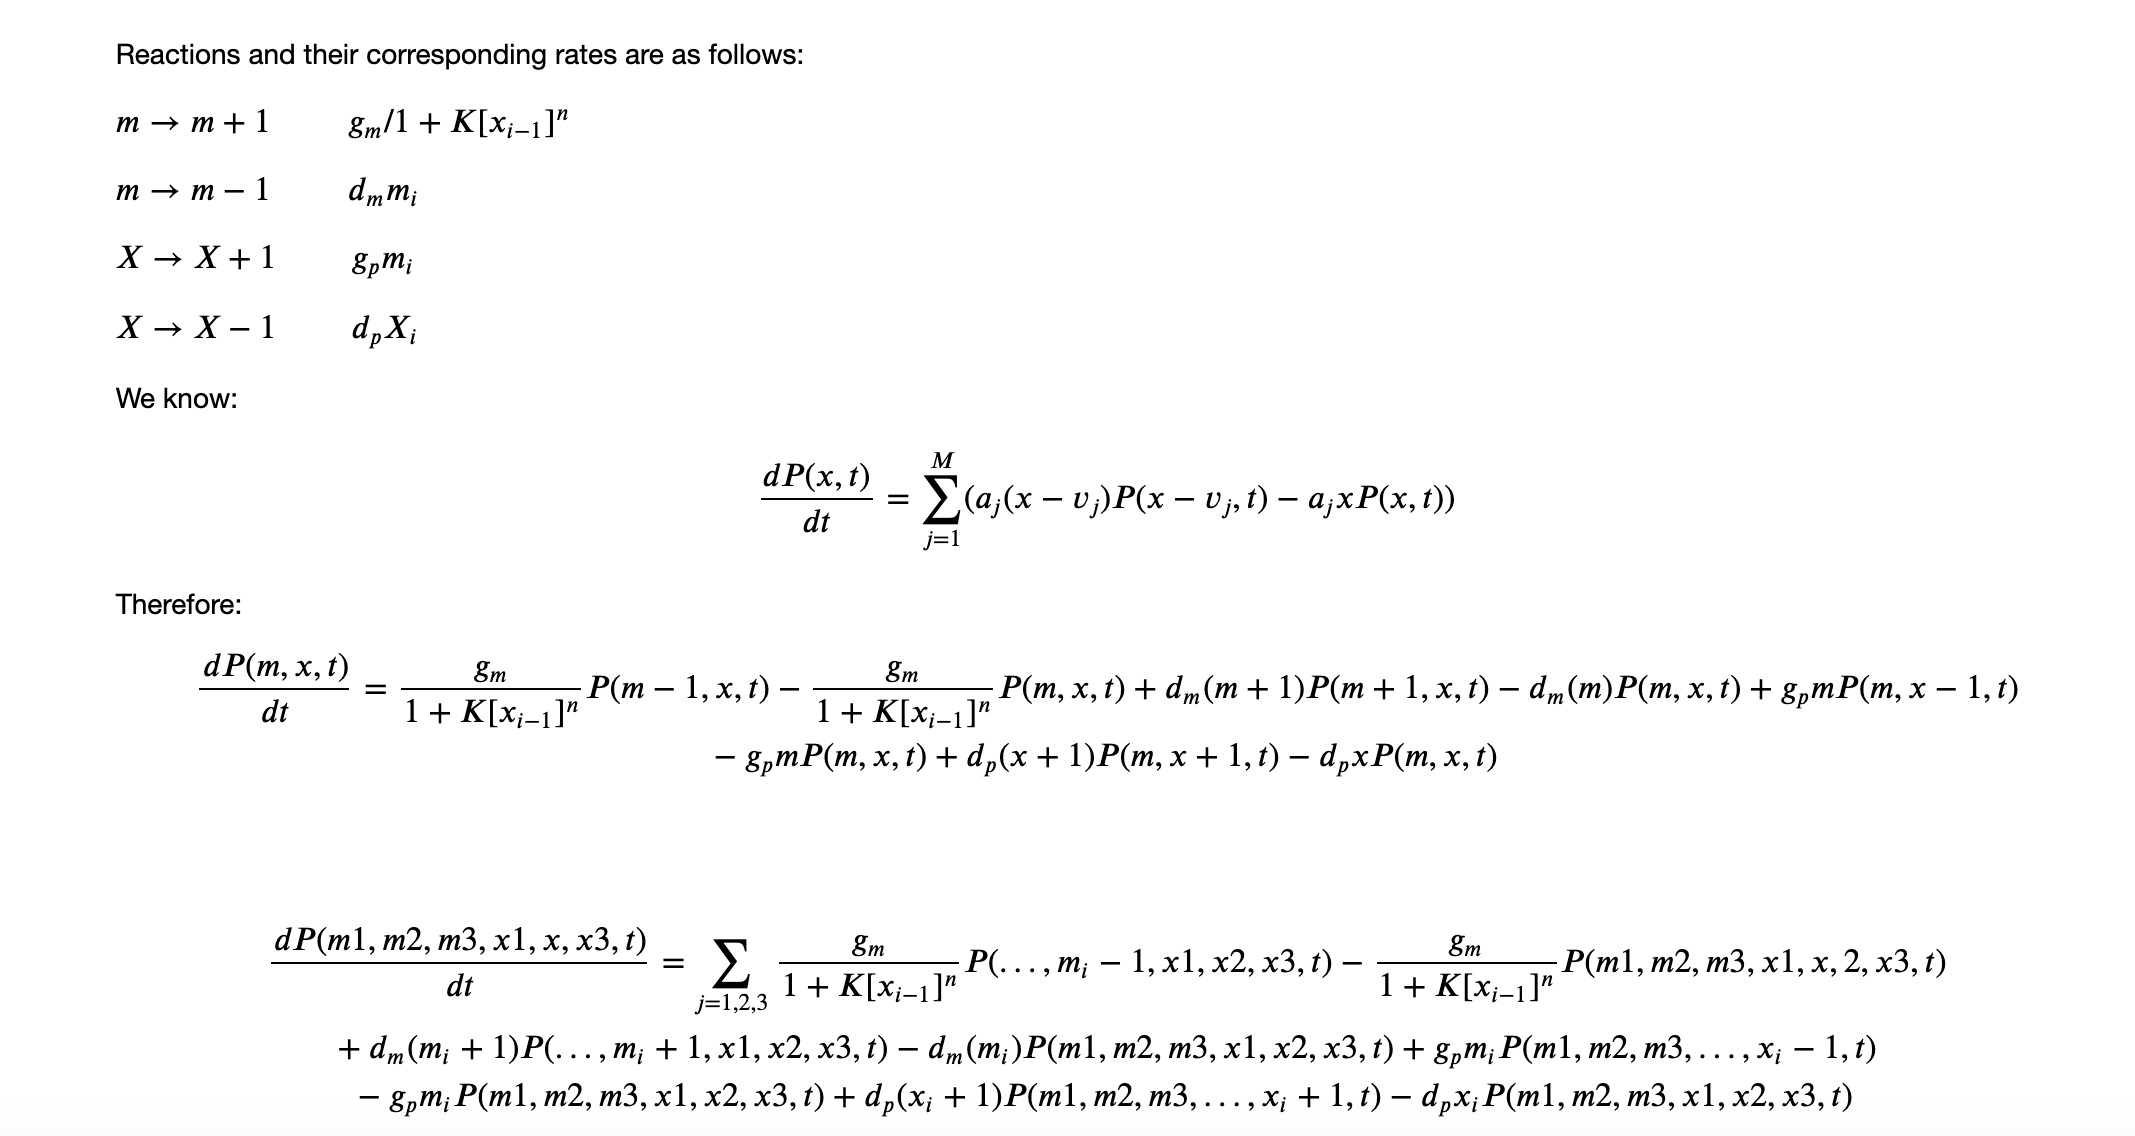

In [4]:
def Sim_func(size,maxtime,x):
    '''
    Performs SSA
    param:: size:
    param:: maxtime:
    param:: x: initial conditions for x=[m1,m2,m3,x1,x2,x3]
    return:: t,v
    '''    
    t = np.zeros(size)               #reaction times
    v = np.zeros((size, 6))          #molecular count 
    events = [(+1,0,0,0,0,0),(-1,0,0,0,0,0),(0,0,0,+1,0,0),(0,0,0,-1,0,0),(0,+1,0,0,0,0),(0,-1,0,0,0,0),
    (0,0,0,0,+1,0),(0,0,0,0,-1,0),(0,0,+1,0,0,0),(0,0,-1,0,0,0),(0,0,0,0,0,+1),(0,0,0,0,0,-1)]

    #no_events = np.arange(0,len(events),1)
    v[0] = np.zeros((size, 6))[0] + x
    ns = 0
    time = 0
    while time <= maxtime:       
        rates = np.array([gm/(1+k*v[(ns, 5)]**n),dm*v[(ns, 0)],gp*v[(ns, 0)],dp*v[(ns, 3)], 
                          gm/(1+k*v[(ns, 3)]**n),dm*v[(ns, 1)],gp*v[(ns, 1)],dp*v[(ns, 4)],
                          gm/(1+k*v[(ns, 4)]**n),dm*v[(ns, 2)],gp*v[(ns, 2)],dp*v[(ns, 5)]])     
        total_rate  =  sum(rates)
        dt = -math.log(1 - random.uniform(0.0, 1.0)) / total_rate 
        choose = np.random.choice(np.arange(len(events)), size=1, p=rates/total_rate)[0]
        v[ns+1] = v[ns]+ events[choose]
        t[ns+1]= t[ns]+dt
        ns = ns + 1
        time = time +dt
        if ns == size-1:
            break
    return t[0:ns], v[0:ns]

def subsample(t_x,x,dt,N):
    '''Subsamples the SSA-generated trajectories
    param:: t_x: reaction times
    param:: x: molecule count
    param:: dt: subsampling interval length
    param:: N: maximum observation time 
    return:: y 
    '''
    L=int((N+1)*(1./dt))
    y=np.zeros(L)
    #print(L)
    y[0]=x[0]
    dummy=0
    index=1
    for k in range(1,len(t_x)):
        if t_x[k]>dummy: #& index<(L-2):
            #print(index)
            y[index]=x[k-1]
            dummy+=dt
            index+=1
    return y

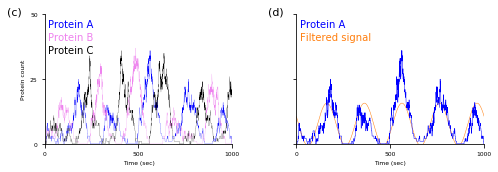

In [6]:
'''Here we simulate the stochastic version of the repressilator. We plot the protein trajectories.'''
k = 1 #repression strength (affinity between TF and promoter)
dm = 0.05 #degradation rate fo mRNA
gm = 1.5 #Transcription rate of mRNA
dp = 0.1 #degradation rate of protein
gp = 0.1 #translation rate of protein
n = 2 #Hill coefficient constant
x=[0,0,0,0,0,0]     #x=[m1,m2,m3,x1,x2,x3] initial conditions
maxtime=1000
t,v = Sim_func(10000,maxtime,x)

fontsiz=10
f,axes=plt.subplots(1,2,figsize=(7,2.5))
plt.rcParams['font.size'] = fontsiz
axes[0].plot(t,v[:,[3]],linewidth=0.2,color='b')
axes[0].plot(t,v[:,[4]],linewidth=0.2,color='violet')
axes[0].plot(t,v[:,[5]],linewidth=0.2,color='k')
axes[0].set_ylabel("Protein count")



'''Here, we take Protein A, and filter the signal by FFT to remove noise. We first compute the FFT of the signal
and take the Power Spectrum (variable PSD here). We set a certain threshold for PSD and zero out all other FFT coefficient
below this threshold. We return to the temporal space by taking the I-FFT of the filtered signal.'''
x1 = v[:,[3]].reshape(-1)
dt=0.2
x1_subsampled=subsample(t,x1,dt,int(np.round(max(t))))
x1_hat=scipy.fft(x1_subsampled)
PSD=x1_hat*np.conj(x1_hat)/len(x1_hat)
freq=(1/(dt*len(x1_subsampled)))*np.arange(len(x1_subsampled))
indices=PSD>50000
x1_filtered=scipy.ifft(x1_hat*indices)
axes[1].plot(np.arange(0,int(len(x1_filtered)*dt),dt),x1_filtered,label='Filtered iFFT',linewidth=0.5,color='C1')
axes[1].plot(t,x1,linewidth=0.5,label='Original Signal',color='b')
for i in range(2):
    axes[i].spines['top'].set_color('none')
    axes[i].spines['right'].set_color('none')
    axes[i].set_yticks([0,25,50])
    axes[i].set_xticks([0,500,1000])
    axes[i].set_xlim([0,1000])
    axes[i].set_xlabel("Time (sec)")
    axes[i].set_ylim([0,50])
axes[1].set_yticklabels('')
axes[0].text(20,45,'Protein A',color='b')
axes[0].text(20,40,'Protein B',color='violet')
axes[0].text(20,35,'Protein C',color='k')
axes[1].text(20,45,'Protein A',color='b')
axes[1].text(20,40,'Filtered signal',color='C1')

axes[0].text(-200,50,'(c)',fontsize=fontsiz+1)
axes[1].text(-150,50,'(d)',fontsize=fontsiz+1)
plt.tight_layout(w_pad=3)

f.savefig('4.4.trajectory.jpg', format='jpg', dpi=500,bbox_inches="tight")


The signal filtering by FFT reveals dominant signals that clearly exhibit periodicity and oscillation in the data.